In [3]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


Text(0.5,0.92,'Uniform prior landscape; alterate view')

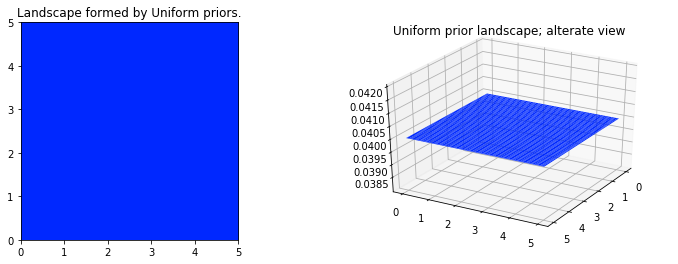

In [6]:
figsize(12.5, 4)

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
              cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title('Landscape formed by Uniform priors.')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title('Uniform prior landscape; alterate view')

Text(0.5,0.92,'$Exp(3), Exp(10)$ prior landscape; \nalternate view')

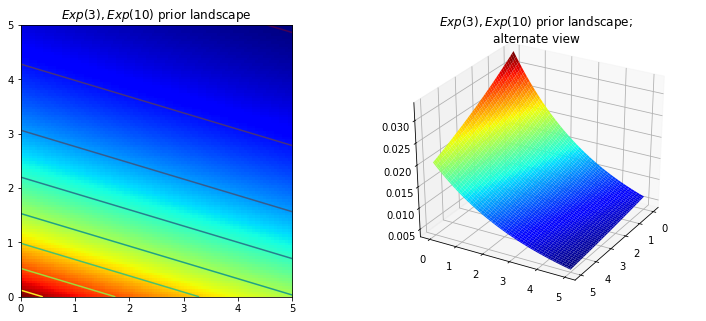

In [8]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
               cmap=jet, extent=(0, 5, 0, 5))

plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view")